In [56]:
import os

In [31]:
stream = os.popen('./Quicksort')

In [32]:
stream.read()

'1485'

In [1]:
import random

In [63]:
A = [random.random() for i in range(1000)]

In [31]:
f = open('./vector.dat')

In [32]:
f.write(str(A).replace(',','\n')[1:-1])

UnsupportedOperation: not writable

In [57]:
stream = os.popen('./Quicksort')

In [59]:
stream.read()

'3.07601e-318 \n133\n1\n'

In [2]:
import matplotlib.pyplot as plt

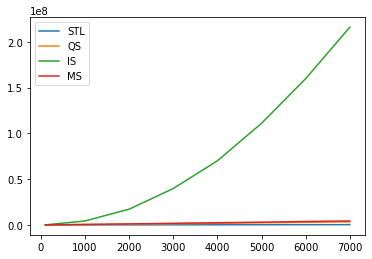

In [24]:
#standard
STL = [2234,31391,68435,111965,151909,197017,244920,296511]
IS = [47230,4347417,17213931,39799083,70026916,110974583,159698892,215815064]
QS = [24176,369733,804331,1287693,1764114,2351162,2804133,3299814]
MS = [47976,546042,1124810,1781509,2382906,2997215,3742317,4348012] 

X = [100,1000, 2000,3000,4000,5000,6000,7000]
plt.plot(X,STL, label='STL')
plt.plot(X,QS, label='QS')
plt.plot(X,IS, label='IS')
plt.plot(X,MS, label='MS')

plt.legend()

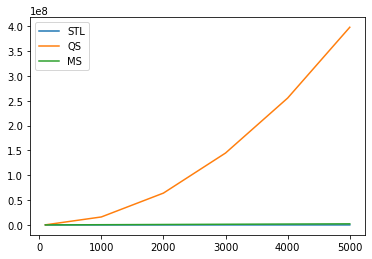

In [ ]:
#sorted
STL = [310,1567,2870,4205,5489,6815]
IS = [2456,22604,44837,68374,89968,112042]
QS = [170876,16027772,64076748,144768240,255448318,397985693]
MS = [38194,413722,851763,1309844,1737157,2152024] 
X = [100,1000, 2000,3000,4000,5000]
plt.plot(X,STL, label='STL')
plt.plot(X,QS, label='QS')
#plt.plot(X,IS, label='IS')
plt.plot(X,MS, label='MS')
plt.legend()

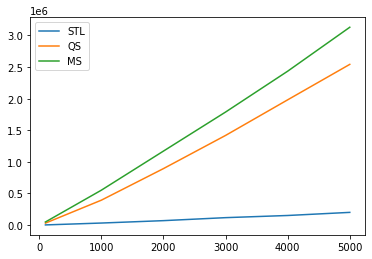

In [36]:
#random
STL = [2283,31937,69842,117224,151454,200728]
IS = [50787,6758885,27912929,57118705,99165978,148764046]
QS = [30655,393554,893297,1418128,1981639,2542636]
MS = [48557,551716,1170352,1788056,2434697,3130105]
X = [100,1000, 2000,3000,4000,5000]
plt.plot(X,STL, label='STL')
plt.plot(X,QS, label='QS')
#plt.plot(X,IS, label='IS')
plt.plot(X,MS, label='MS')
plt.legend()

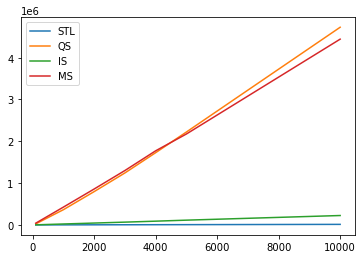

In [34]:
#sorted + random
STL = [328,1556,2852,4125,5469,6753,13324]
IS = [2446,22662,44867,66924,90077,114152,225080]
QS = [25614,365092,797533,1243880,1728355,2222539,4727461]
MS = [42451,427001,859891,1301663,1773123,2175167,4442688]
X = [100,1000, 2000,3000,4000,5000,10000]
plt.plot(X,STL, label='STL')
plt.plot(X,QS, label='QS')
plt.plot(X,IS, label='IS')
plt.plot(X,MS, label='MS')
plt.legend()

In [ ]:
#pochi valori diversi + random
STL = [328,1556,2852,4125,5469,6753]
IS = [2446,22662,44867,66924,90077,114152]
QS = [25614,365092,797533,1243880,1728355,2222539]
MS = [42451,427001,859891,1301663,1773123,2175167]
X = [100,1000, 2000,3000,4000,5000]
plt.plot(X,STL, label='STL')
plt.plot(X,QS, label='QS')
plt.plot(X,IS, label='IS')
plt.plot(X,MS, label='MS')
plt.legend()